In [20]:
import math
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import  MiniBatchKMeans
import numpy as np
import pandas as pd
from joblib import dump, load
from sklearn.preprocessing import MinMaxScaler
from utils_hmm import *

%autosave 0 

Autosave disabled


In [21]:
both=False
data=pd.read_csv('dataset_cnns/resnet_lidar_odom.txt')
cols=['x','y','theta']
n_reads=data.shape[1]-3
n_reads
etiquetas=[]
for i in range (n_reads):
    etiquetas.append('R'+str(i))

        
for lab in cols:
    etiquetas.append(lab)
data.columns=etiquetas
resnet_feats= data.iloc[:,:-724]
lecs= data.iloc[:,-724:-3]
xyth=data.iloc[:,-3:]


In [22]:
lecs.shape, resnet_feats.shape , xyth.shape

((15494, 721), (15494, 1536), (15494, 3))

In [23]:
print( 'There are ',data.isnull().sum().sum(),'nans','removing')
data.fillna(0,inplace=True)
print( 'There are ',data.isnull().sum().sum(),'nans','left')


('There are ', 0, 'nans', 'removing')
('There are ', 0, 'nans', 'left')


In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
normalize=True
if (normalize):
    scaler= MinMaxScaler()
    norm_resnet= pd.DataFrame(scaler.fit_transform(resnet_feats))
    norm_xyth  = pd.DataFrame(scaler.fit_transform(xyth))
    norm_lecs   = pd.DataFrame(scaler.fit_transform(lecs))
    norm_resnet.shape ,norm_lecs.shape , norm_xyth.shape
else:
    norm_resnet= resnet_feats
    norm_xyth  = xyth
    norm_lecs   =  lecs
    norm_resnet.shape ,norm_lecs.shape , norm_xyth.shape
    

In [26]:
lecs= pd.concat((norm_resnet,norm_lecs), axis=1)
lecs.shape

(15494, 2257)

In [27]:
get_new_ccs=True
Q_aff=False
if get_new_ccs:
    
    K_corpus=256
    N=16
    
    kmedias=MiniBatchKMeans(init='k-means++', n_clusters=K_corpus, batch_size=1000,
                      n_init=10, max_no_improvement=10, verbose=0)
    kmedias.fit(lecs)
    ccvk=kmedias.cluster_centers_
    
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=N, batch_size=1000,
                      n_init=10, max_no_improvement=10, verbose=0)
    mbk.fit(xyth)
    ccxyth=mbk.cluster_centers_
else:
    ccxyth,ccvk=np.load('ccxyth.npy'),np.load('ccvk.npy')
    print("CUANTIZANDO SIN RECALCULAR CC")
aus=[]
auvks=[]
au_resnets=[]
for i,lec in zip(xyth.values, lecs.values):

    _, au= quantized(i , ccxyth)
    aus.append(au)

    auvk= np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin()
    auvks.append(auvk)
    
data['Y']=aus
data['Vk']=auvks
#data['Vk_resnet']=au_resnets


if (Q_aff==True):
    clf=load('aff_prop_class.joblib') ##PYTHON VERSION 2 
    data['Vk_aff']=clf.predict(lecs)


if (Q_aff!=True):
    data['Vk_aff']=data['Vk']

obs,est= data['Vk'].values,data['Y'].values
obs_aff= data['Vk_aff'].values
np.save('obs.npy',obs)
np.save('est.npy',est)
np.save ('ccxyth.npy',ccxyth)

print('new obs/ est almacenados')
data['Y'].describe()   

new obs/ est almacenados


count    15494.000000
mean         7.763070
std          4.575388
min          0.000000
25%          4.000000
50%          8.000000
75%         12.000000
max         15.000000
Name: Y, dtype: float64

In [28]:
data.head()

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,R2253,R2254,R2255,R2256,x,y,theta,Y,Vk,Vk_aff
0,0.0,0.0,0.0,471.43164,0.0,0.0,460.34943,0.0,317.43176,176.56514,...,1.913227,1.893057,1.873370,1.854151,0.000156,-0.001345,-0.012257,5,4,4
1,0.0,0.0,0.0,471.43176,0.0,0.0,460.34955,0.0,317.43190,176.56499,...,1.917529,1.897250,1.877459,1.858139,-0.000011,-0.001489,-0.013584,5,4,4
2,0.0,0.0,0.0,471.43204,0.0,0.0,460.34990,0.0,317.43216,176.56544,...,1.917636,1.897354,1.877560,1.858237,-0.000015,-0.001492,-0.013617,5,4,4
3,0.0,0.0,0.0,471.43167,0.0,0.0,460.34952,0.0,317.43213,176.56523,...,1.917728,1.897444,1.877647,1.858323,-0.000018,-0.001496,-0.013645,5,4,4
4,0.0,0.0,0.0,471.43164,0.0,0.0,460.34950,0.0,317.43195,176.56543,...,1.917924,1.897635,1.877833,1.858504,-0.000026,-0.001503,-0.013705,5,4,4


In [29]:

#data.to_csv('dataset_cnns/fast_load.csv')


In [31]:
test_data= pd.read_csv('dataset_cnns/validation_resnet_lidar_odom.txt')
cols=['x','y','theta']
n_reads=test_data.shape[1]-3
n_reads
etiquetas=[]
for i in range (n_reads):
    etiquetas.append('R'+str(i))

        
for lab in cols:
    etiquetas.append(lab)
test_data.columns=etiquetas
resnet_feats= test_data.iloc[:,:-724]
test_lecs= test_data.iloc[:,-724:-3]
test_xyth=test_data.iloc[:,-3:]


In [33]:
get_new_ccs=False
Q_aff=False
if get_new_ccs:
    
    K_corpus=256
    N=16
    
    kmedias=MiniBatchKMeans(init='k-means++', n_clusters=K_corpus, batch_size=1000,
                      n_init=10, max_no_improvement=10, verbose=0)
    kmedias.fit(lecs)
    ccvk=kmedias.cluster_centers_
    
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=N, batch_size=1000,
                      n_init=10, max_no_improvement=10, verbose=0)
    mbk.fit(xyth)
    ccxyth=mbk.cluster_centers_
else:
    ccxyth,ccvk=np.load('ccxyth.npy'),np.load('ccvk.npy')
    print("CUANTIZANDO SIN RECALCULAR CC")
aus=[]
auvks=[]
au_resnets=[]
for i,lec in zip(test_xyth.values, test_lecs.values):

    _, au= quantized(i , ccxyth)
    aus.append(au)

    auvk= np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin()
    auvks.append(auvk)
    
test_data['Y']=aus
test_data['Vk']=auvks
#test_data['Vk_resnet']=au_resnets


if (Q_aff==True):
    clf=load('aff_prop_class.joblib') ##PYTHON VERSION 2 
    test_data['Vk_aff']=clf.predict(lecs)


if (Q_aff!=True):
    test_data['Vk_aff']=test_data['Vk']

test_obs,test_est= test_data['Vk'].values,test_data['Y'].values
test_obs_aff= test_data['Vk_aff'].values


test_data['Y'].describe()   

CUANTIZANDO SIN RECALCULAR CC


count    656.000000
mean       7.579268
std        5.664120
min        0.000000
25%        1.000000
50%        9.000000
75%       12.000000
max       15.000000
Name: Y, dtype: float64

In [34]:
test_data.head()

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,R2253,R2254,R2255,R2256,x,y,theta,Y,Vk,Vk_aff
0,0.0,0.0,0.0,73.056920,0.0,0.0,55.939632,0.0,58.184982,29.842196,...,2.184928,2.171221,2.157758,2.144534,0.567805,0.142187,0.232104,6,230,230
1,0.0,0.0,0.0,66.048870,0.0,0.0,51.827000,0.0,52.322190,26.228790,...,2.819890,2.814898,2.810019,2.805252,1.824882,0.477268,0.760496,15,11,11
2,0.0,0.0,0.0,50.580498,0.0,0.0,35.144566,0.0,40.039707,14.367193,...,2.840186,2.836911,2.833740,2.830672,1.925806,0.478450,0.860118,15,11,11
3,0.0,0.0,0.0,50.865875,0.0,0.0,34.981260,0.0,40.397410,13.911379,...,2.840587,2.837316,2.834149,2.831085,1.926375,0.478292,0.860376,15,11,11
4,0.0,0.0,0.0,50.627040,0.0,0.0,35.032856,0.0,40.127934,14.147972,...,2.840994,2.837726,2.834562,2.831501,1.926914,0.478119,0.860580,15,11,11


In [35]:
save=True

In [36]:
####BAUM WELCH APPROX###############???!?!?!
if save:
    N=est.max()+1 
    K_corpus= obs.max()+1
    TRANS=np.zeros((N,N))
    for i in range (N):
        fromTO=[]


        indices=np.asarray(np.where(est==i)).ravel()


        for indice in indices:

            if (int(indice)==len(est)-1):

                indice=indice-1

            fromTO.append(est[indice+1])
        fromTO.append(0)
        fromTO.append(N-1)
        aux=np.asarray(np.bincount(fromTO    ))
        aux[0]=aux[0]-1
        aux[N-1]=aux[N-1]-1

        TRANS[i,:]=aux
    TRANS=TRANS/TRANS.sum(axis=1)
    #####################################3
    EMIS= np.zeros((N,K_corpus))
    for Vk in range (K_corpus):

        indices=np.asarray(np.where(obs==Vk)).ravel()
        estconvk= est[indices]

        numestenvk=np.bincount(estconvk)
        if (N-len(numestenvk)>0):
            numestenvk=np.append(numestenvk, np.zeros(N-len(numestenvk)))
        EMIS[:,Vk]=(numestenvk/np.bincount(est)+.00001)

    A,B=TRANS,EMIS
    PI=np.ones(N)/N
    Modelo1=HMM(A,B,PI)




    #np.linalg.norm(Modelo1.A-Modelo2.A)
    np.save('A.npy',Modelo1.A)
    np.save('B.npy',Modelo1.B)
    np.save('PI.npy',Modelo1.PI)
    print("MODEL SAVED")
else:
    A,B,PI = np.load('A.npy'),np.load('B.npy'),np.load('PI.npy')
    Modelo1=HMM(A,B,PI)
B.shape

MODEL SAVED


(16, 256)

In [37]:
data.head()

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,R2253,R2254,R2255,R2256,x,y,theta,Y,Vk,Vk_aff
0,0.0,0.0,0.0,471.43164,0.0,0.0,460.34943,0.0,317.43176,176.56514,...,1.913227,1.893057,1.873370,1.854151,0.000156,-0.001345,-0.012257,5,4,4
1,0.0,0.0,0.0,471.43176,0.0,0.0,460.34955,0.0,317.43190,176.56499,...,1.917529,1.897250,1.877459,1.858139,-0.000011,-0.001489,-0.013584,5,4,4
2,0.0,0.0,0.0,471.43204,0.0,0.0,460.34990,0.0,317.43216,176.56544,...,1.917636,1.897354,1.877560,1.858237,-0.000015,-0.001492,-0.013617,5,4,4
3,0.0,0.0,0.0,471.43167,0.0,0.0,460.34952,0.0,317.43213,176.56523,...,1.917728,1.897444,1.877647,1.858323,-0.000018,-0.001496,-0.013645,5,4,4
4,0.0,0.0,0.0,471.43164,0.0,0.0,460.34950,0.0,317.43195,176.56543,...,1.917924,1.897635,1.877833,1.858504,-0.000026,-0.001503,-0.013705,5,4,4


In [45]:
cc=test_data[['x','y','theta']].values

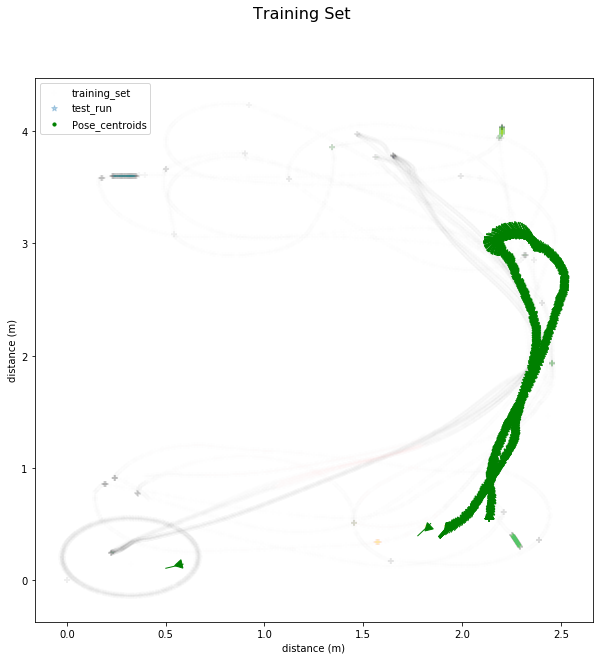

In [46]:
#cc=ccxyth
#cc=



fig = plt.figure(figsize=(10,10))
fig.suptitle('Training Set ', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Y,alpha=.00313 , label='training_set')
ax1.scatter(x= test_data.x, y=test_data.y,marker='*',c=test_data.Y,alpha=.313 , label='test_run')
ax1.set_xlabel('distance (m)')
ax1.set_ylabel('distance (m)')




cords3=path_to_xy(np.arange(0,Modelo1.A.shape[0]),cc)
ax1.scatter(x= cords3.xcuant, y=cords3.ycuant ,marker='.',s=40,c='g',label='Pose_centroids')
for c in cc:
        ang=c[2]*180/math.pi
        

        ax1.plot(c[0], c[1], marker=(3, 1,ang + 90 ), markersize=10,c='green', linestyle='None')
        ax1.plot(c[0]-(.01*np.cos(c[2])), c[1]-(.01*np.sin(c[2])), marker=(1, 1,ang+ 90), markersize=25,c='green', linestyle='--')

ax1.legend()


In [42]:

def plot_cc_arrow(cc):
    fig=plt.figure(figsize=(10,10))
    fig.suptitle('Pose Centroids ', fontsize=16)

    ax1= fig.add_subplot(111)
    ax1.set_xlabel('distance (m)')
    ax1.set_ylabel('distance (m)')


    for c in cc:
        ang=c[2]*180/math.pi
        

        plt.plot(c[0], c[1], marker=(3, 1,ang + 90 ), markersize=10,c='green', linestyle='None')
        plt.plot(c[0]-(.01*np.cos(c[2])), c[1]-(.01*np.sin(c[2])), marker=(1, 1,ang+ 90), markersize=25,c='green', linestyle='--')
        #plt.plot(c[0]-(.01*np.cos(c[2]+.5*math.pi)), c[1]-(.01*np.sin(c[2]+.5*math.pi)), marker=(1, 1,ang), markersize=25,c='blue', linestyle='--')

    #plt.xlim([0,4])
    #plt.ylim([0,4])

    plt.show()

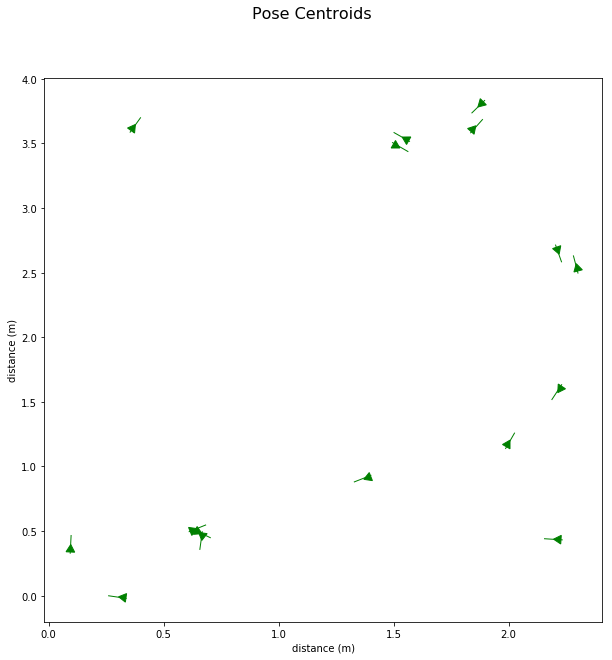

In [26]:
fig=plt.figure(figsize=(10,10))
plot_cc_arrow(cc)


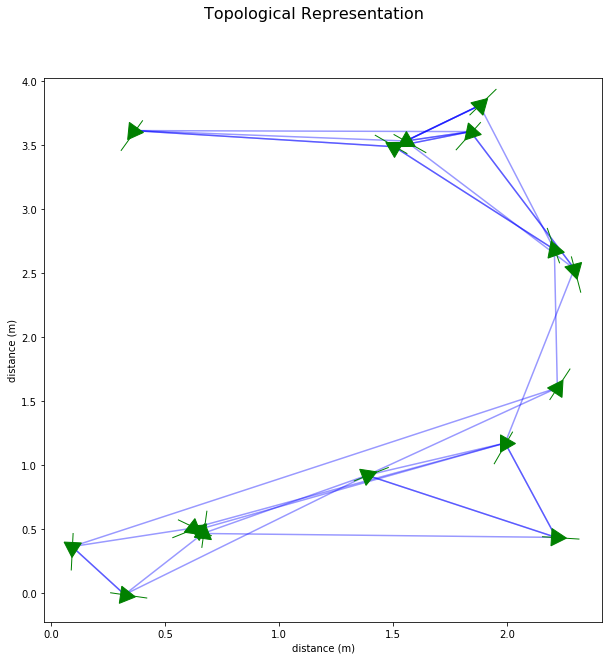

In [27]:
cc=ccxyth



x=np.linspace(0,.4)
fig = plt.figure(figsize=(10,10))
fig.suptitle('Topological Representation', fontsize=16)
euclD=np.zeros((N,N,1))
ss= np.arange(len(A))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('distance (m)')
ax1.set_ylabel('distance (m)')

for s1 in ss:
    for s2 in ss:
        if (s1!=s2)and (A[s1,s2]!=0):# and (np.linalg.norm(ccxyth[s1,:2]-ccxyth[s2,:2])<1)   :#and(s1==s or s2==s)
            xvalues=[ccxyth[s1,0],ccxyth[s2,0]]
            yvalues=[ccxyth[s1,1],ccxyth[s2,1]]
            euclD[s1,s2]=np.linalg.norm(ccxyth[s1,:2]-ccxyth[s2,:2])

            

            plt.plot(xvalues,yvalues ,alpha=.4 ,c='b' )
         
            scatter= ax1.scatter(x= ccxyth[s1,0], y=ccxyth[s1,1],c='b' ,marker='.',s=100)
            scatter= ax1.scatter(x= ccxyth[s2,0], y=ccxyth[s2,1],c='b' ,marker='.',s=100)
            #scatter= ax1.scatter(x= trans[s1,s2,0], y=trans[s1,s2,1],c='b' ,marker='|',s=140)
for c in cc:
        ang=c[2]*180/math.pi
        plt.plot(c[0], c[1], marker=(3, 1,ang - 90 ), markersize=20,c='green', linestyle='None')
        plt.plot(c[0]-(.01*np.cos(c[2])), c[1]-(.01*np.sin(c[2])), marker=(1, 1,ang- 90), markersize=50,c='green', linestyle='--')




In [37]:


buf_vit=100
indice= int(np.random.rand()*(len(obs)-2*buf_vit)) #7493
for i in range(1):
    
   
    obs_windowed= obs[indice:indice+buf_vit]
    
    est_windowed= est[indice:indice+buf_vit]
    
    odomreal= data[['x','y']].iloc[indice:indice+buf_vit]
    #print(data[['x','y']].iloc[indice:indice+buf_vit],est_windowed)

    print(indice)
    #PATH from Model 1 KMEANS CC's obs
    path= viterbi(obs_windowed,Modelo1,Modelo1.PI)
    
    ##PATH FROM MODEL 2 WICH NEEDS AFF PORP QUANT OBS
    
    yhat=np.zeros(len(path)-1)
    
    ytrue=np.zeros(len(path)-1)
    for i in range(len(path)-1):
        yhat[i]=int(path[i])
    
        ytrue[i]=int(est_windowed[i])
    print(accuracy(ytrue,yhat))


11673
0.0


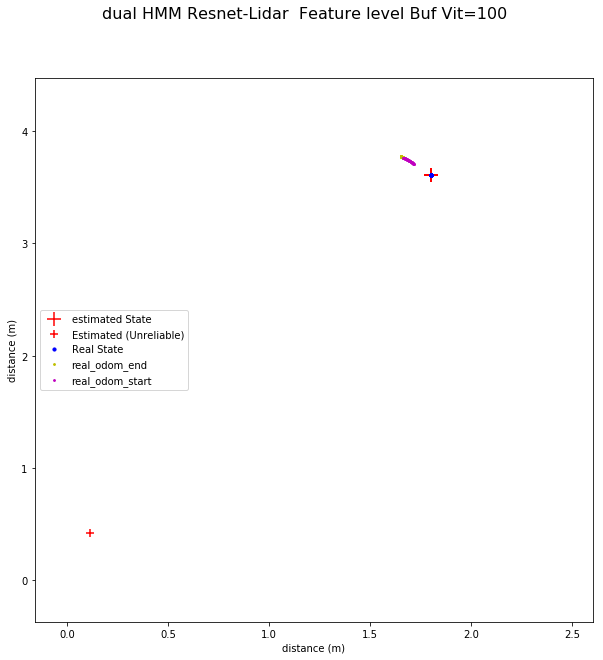

In [96]:
cc=ccxyth
paths= viterbi(obs_windowed,Modelo1,Modelo1.PI)  
path=paths[int(-len(paths)/2):]
path_bigdelay = paths[:int(-len(paths)/2)]
cords= path_to_xy(path,cc)
cords_bigdelay = path_to_xy(path_bigdelay,cc)
cords1=path_to_xy(est_windowed.T,cc)




fig = plt.figure(figsize=(10,10))
fig.suptitle('dual HMM Resnet-Lidar  Feature level Buf Vit='+str(buf_vit), fontsize=16)

ax1 = fig.add_subplot(111)

ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Y,alpha=.0000313, label='')

ax1.scatter(x=cords.xcuant, y=cords.ycuant, marker='+',c='r',s=200, label='estimated State')
ax1.scatter(x=cords_bigdelay.xcuant, y=cords_bigdelay.ycuant, marker='+',c='r',s=52  ,label='Estimated (Unreliable)')
ax1.scatter(x=cords1.xcuant, y=cords1.ycuant, marker='o',c='b',s=10   , label='Real State')

ax1.scatter(x= odomreal.x[int(-len(paths)/2):], y=odomreal.y[int(-len(paths)/2):],marker='.',s=13,c='y',label='real_odom_end')
ax1.scatter(x= odomreal.x[:int(-len(paths)/2)], y=odomreal.y[:int(-len(paths)/2)],marker='.',s=13,c='m',label='real_odom_start')
cords3=path_to_xy(np.arange(0,Modelo1.A.shape[0]),cc)
#ax1.scatter(x= cords3.xcuant, y=cords3.ycuant ,marker='.',s=40,c='g', label='Pose Corpus')

ax1.set_xlabel('distance (m)')
ax1.set_ylabel('distance (m)')
#

ax1.legend()


In [19]:



buf_vit=40
for i in range(1):
    
    
    obs_windowed= obs[indice:indice+buf_vit]
    
    est_windowed= est[indice:indice+buf_vit]
    odomreal= data[['x','y']].iloc[indice:indice+buf_vit]
    #print(data[['x','y']].iloc[indice:indice+buf_vit],est_windowed)

    print(indice)
    path= viterbi(obs_windowed,Modelo1,Modelo1.PI)
   
    yhat=np.zeros(len(path)-1)
   
    ytrue=np.zeros(len(path)-1)
    for i in range(len(path)-1):
        yhat[i]=int(path[i])
   
        ytrue[i]=int(est_windowed[i])
    print(accuracy(ytrue,yhat))

13469
0.0


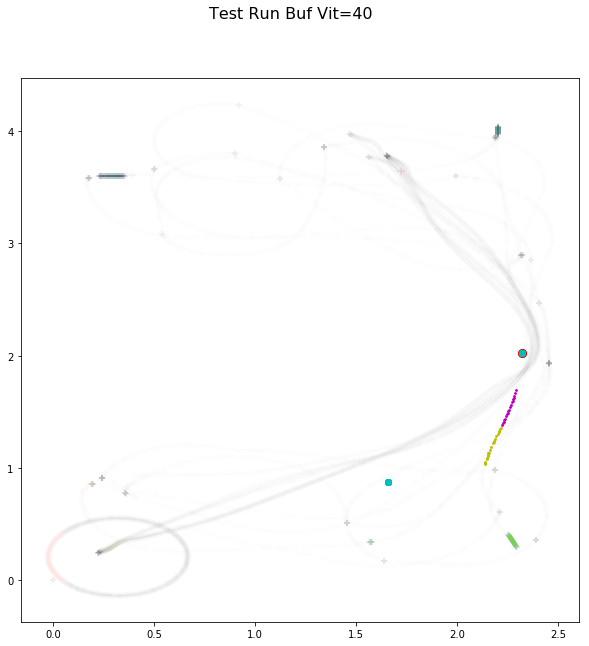

In [20]:
cc=ccxyth
paths= viterbi(obs_windowed,Modelo1,Modelo1.PI)
path=paths[int(-len(paths)/2):]
path_bigdelay = paths[:int(-len(paths)/2)]
cords= path_to_xy(path,cc)
cords_bigdelay = path_to_xy(path_bigdelay,cc)
cords1=path_to_xy(est_windowed.T[int(-len(paths)/2):],cc)
cords1delay=path_to_xy(est_windowed.T[:int(-len(paths)/2)],cc)



fig = plt.figure(figsize=(10,10))
fig.suptitle('Test Run Buf Vit=40', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Y,alpha=.00313)

ax1.scatter(x=cords.xcuant, y=cords.ycuant, marker='o',c='r',s=52,alpha=.5 )
ax1.scatter(x=cords_bigdelay.xcuant, y=cords_bigdelay.ycuant, marker='+',c='r',s=52,alpha=.1 )
ax1.scatter(x=cords1.xcuant, y=cords1.ycuant, marker='o',c='c' ,alpha=.5)
ax1.scatter(x=cords1delay.xcuant, y=cords1delay.ycuant, marker='+',c='c' ,alpha=.1)



ax1.scatter(x= odomreal.x[int(-len(paths)/2):], y=odomreal.y[int(-len(paths)/2):],marker='.',s=13,c='y')
ax1.scatter(x= odomreal.x[:int(-len(paths)/2)], y=odomreal.y[:int(-len(paths)/2)],marker='.',s=13,c='m')



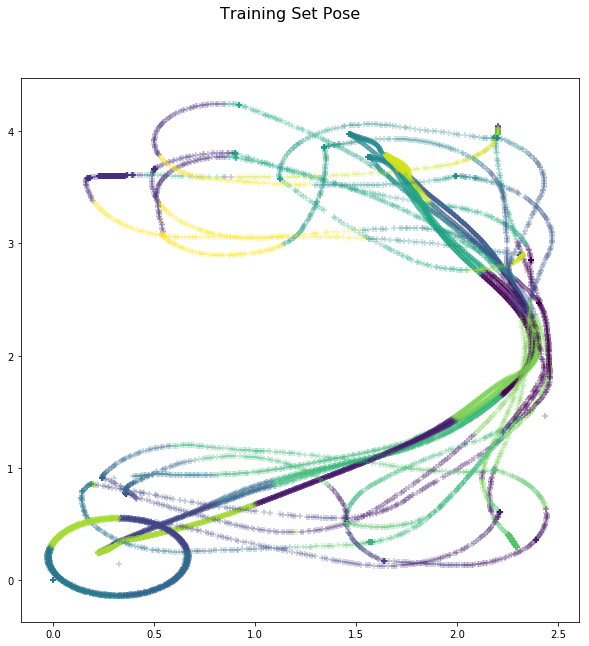

In [32]:


fig = plt.figure(figsize=(10,10))
fig.suptitle('Training Set Pose', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Y,alpha=.3)


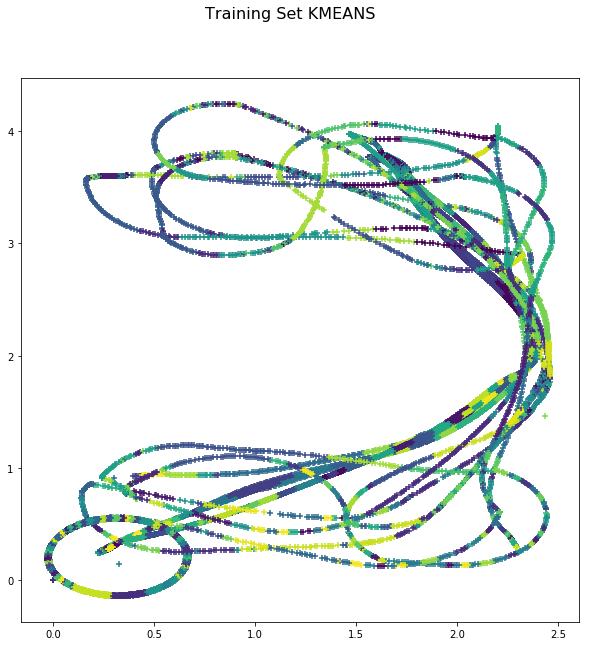

In [33]:


fig = plt.figure(figsize=(10,10))
fig.suptitle('Training Set KMEANS', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Vk)


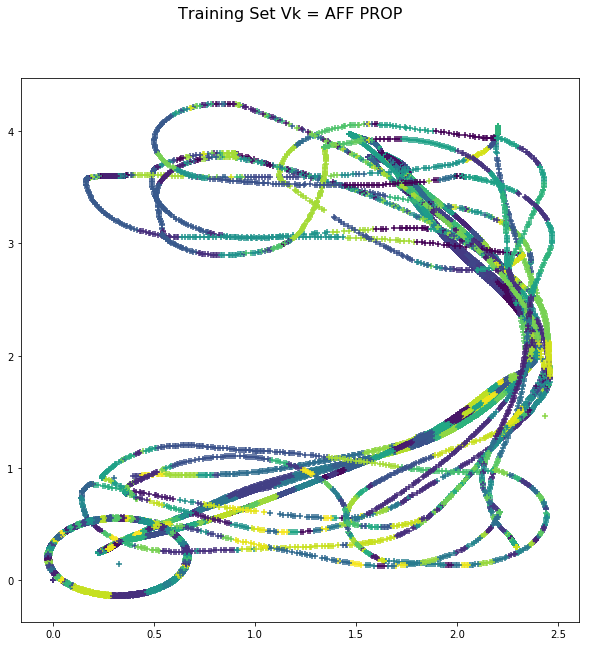

In [34]:


fig = plt.figure(figsize=(10,10))
fig.suptitle('Training Set Vk = AFF PROP', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Vk_aff)


In [35]:
data

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,R2253,R2254,R2255,R2256,x,y,theta,Y,Vk,Vk_aff
0,0.0,0.0,0.000000,471.431640,0.0,0.0,460.349430,0.0,317.431760,176.565140,...,1.913227,1.893057,1.873370,1.854151,0.000156,-0.001345,-0.012257,6,34,34
1,0.0,0.0,0.000000,471.431760,0.0,0.0,460.349550,0.0,317.431900,176.564990,...,1.917529,1.897250,1.877459,1.858139,-0.000011,-0.001489,-0.013584,6,34,34
2,0.0,0.0,0.000000,471.432040,0.0,0.0,460.349900,0.0,317.432160,176.565440,...,1.917636,1.897354,1.877560,1.858237,-0.000015,-0.001492,-0.013617,6,34,34
3,0.0,0.0,0.000000,471.431670,0.0,0.0,460.349520,0.0,317.432130,176.565230,...,1.917728,1.897444,1.877647,1.858323,-0.000018,-0.001496,-0.013645,6,34,34
4,0.0,0.0,0.000000,471.431640,0.0,0.0,460.349500,0.0,317.431950,176.565430,...,1.917924,1.897635,1.877833,1.858504,-0.000026,-0.001503,-0.013705,6,34,34
5,0.0,0.0,0.000000,471.431300,0.0,0.0,460.348940,0.0,317.431700,176.565410,...,1.918025,1.897734,1.877930,1.858598,-0.000030,-0.001506,-0.013736,6,34,34
6,0.0,0.0,0.000000,471.431820,0.0,0.0,460.349370,0.0,317.431820,176.565550,...,1.918114,1.897820,1.878014,1.858680,-0.000033,-0.001510,-0.013763,6,34,34
7,0.0,0.0,0.000000,471.431760,0.0,0.0,460.349520,0.0,317.431980,176.565500,...,1.918214,1.897917,1.878109,1.858773,-0.000037,-0.001512,-0.013794,6,34,34
8,0.0,0.0,0.000000,471.431670,0.0,0.0,460.349330,0.0,317.431850,176.565430,...,1.918315,1.898016,1.878206,1.858867,-0.000041,-0.001515,-0.013825,6,34,34
9,0.0,0.0,0.000000,471.431670,0.0,0.0,460.349400,0.0,317.431980,176.565570,...,1.918412,1.898110,1.878297,1.858956,-0.000045,-0.001519,-0.013855,6,34,34


In [36]:
graphe= Markov_A_2_grafo(A,ccxyth)
ruta=dijkstra(1,6,graphe)


RUTA CALCULADA 


In [37]:

def Markov_A_2_grafo(A,ccxyth):
    dists=np.zeros(A.shape)
    for i in range(A.shape[0]):
        for j in range (A.shape[1]):
            if A[i,j]!=0 :
                dists[i,j]= np.linalg.norm(ccxyth[i]-ccxyth[j])    
    
    
    con = np.where(dists==0,np.inf,dists)
    graphe2=grafo(ccxyth,con)
    return graphe2


In [38]:
graphe= Markov_A_2_grafo(A,ccxyth)


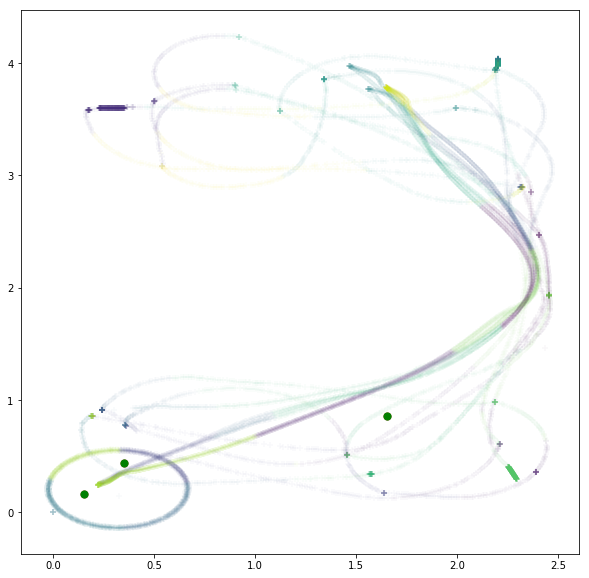

In [39]:
#ruta.append(nodofinal)
path=np.array(ruta)
path
cords_path= path_to_xy(path,cc)
#cords_path= path_to_xy(path[:int(len(path)/2)],cc)

cords_path2= path_to_xy(path,cc)



fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Y,alpha=.0313)

ax1.scatter(x=cords_path.xcuant, y=cords_path.ycuant, marker='o',c='r',s=52,alpha=.5 )
ax1.scatter(x=cords_path2.xcuant, y=cords_path2.ycuant, marker='o',c='g',s=52 )


In [40]:

def dijkstra(nodoinicial,nodofinal,graphe):
    if (nodofinal > graphe.nodos.shape[0]):
        print ('Wrong dimensions for requested node')
        return None

    numnodos= len(graphe.nodos)
    con = graphe.conec
    D= np.ones(numnodos)*np.inf
    Prv= np.ones(numnodos)*np.inf
    V= np.zeros(numnodos)
    a = nodoinicial
    D[a]=0
    Prv[a]=0
    Prv[np.where(con[a]!=np.inf)]=a
    V[a]=1
    Dacc=D[a]
    ########
    D=np.minimum(D,con[a]+D[a])
    cont=0
    sucess=False
    while(sucess==False):
        a = np.argmin(D+np.where (V==1,np.inf, V))
        Dacc=D[a]
        Prv[np.where(D>(con[a]+Dacc) )]=a
        V[a]=1
        D=np.minimum(D,con[a]+Dacc)
        if (a== nodofinal):
            print("RUTA CALCULADA ")
            sucess=True
    rutainv=[]
    rutainv.append(nodofinal)
    while(rutainv[-1]!=nodoinicial):
        prv=Prv[int(rutainv[-1])]
        rutainv.append(prv)

    ruta=[]
    for n in reversed(rutainv):
        ruta.append(n)
    return(ruta)


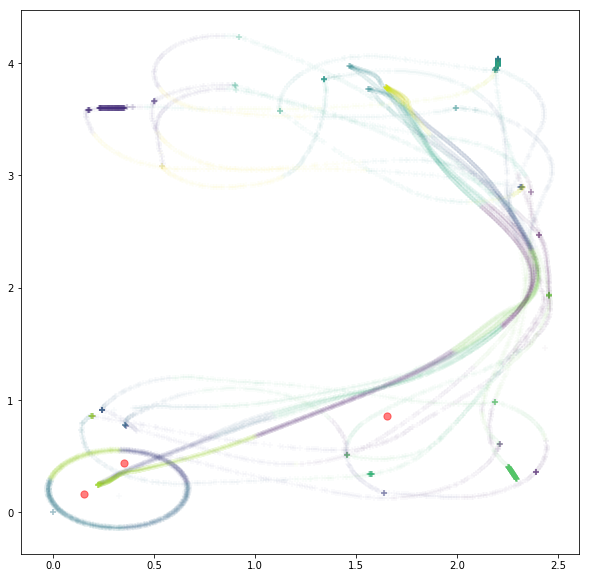

In [41]:
path=np.array(ruta)


cords_path= path_to_xy(path,cc)
#cords_path= path_to_xy(path[:int(len(path)/2)],cc)
#cords_path2= path_to_xy(path[int(len(path)/2):],cc)



fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Y,alpha=.0313)

ax1.scatter(x=cords_path.xcuant, y=cords_path.ycuant, marker='o',c='r',s=52,alpha=.5 )
#ax1.scatter(x=cords_path2.xcuant, y=cords_path2.ycuant, marker='o',c='g',s=52,alpha=.5 )

In [31]:
#lec=np.load('lec.npy')
aux=pd.DataFrame(data.Vk.value_counts())



lec_deseada=aux.index[0]   ###CHOOSING MOST FREQUENT OBSERVATION SYMBOL

lec=data[data.Vk==lec_deseada].sample(n=1,axis=0).iloc[:,:-6].values.ravel()


start_ang=-240/2*np.pi/180
stop_ang= 240/2*np.pi/180
angs=np.linspace(start_ang,stop_ang,num=len(lec))
lec.shape,lec_deseada

((2258,), 121)

In [32]:
cordsy, cordsx= np.cos(angs) *  lec ,  np.sin(angs) *  lec
CORDS=pd.DataFrame((cordsx,cordsy))
CORDS=CORDS.T
CORDS.columns=['x','y']
print(np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin())
lec_leida= np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin()
vec_obs=ccvk[np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin()]
cordsy, cordsx= np.cos(angs) *  vec_obs ,  np.sin(angs) *  vec_obs
CORDS['xx'],CORDS['yy']=cordsx,cordsy


fig = plt.figure(figsize=(10,10))
fig.suptitle('Comparison Between real read and cuantized', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+')
ax1.scatter(x=CORDS.xx,y=CORDS.yy,marker='*')

ValueError: operands could not be broadcast together with shapes (2258,) (256,721) 

In [ ]:
lecs=data[data.Vk==lec_leida]
lecs.shape

In [ ]:
auxy , auxx =np.array([0,0]),np.array([0,0])
start_ang=-250/2*np.pi/180
stop_ang= 250/2*np.pi/180
angs=np.linspace(start_ang,stop_ang,num=len(vec_obs))


lecs=data[data.Vk==lec_leida].sample(n=10,axis=0).iloc[:,:-6]

for  vec_obs in lecs.values.tolist():
    cordsy,cordsx= np.cos(angs) *  vec_obs ,  np.sin(angs) *  vec_obs
    auxy,auxx=np.concatenate((auxy,cordsy)),np.concatenate((auxx,cordsx))
print(lec_leida)    

In [ ]:

CORDS=pd.DataFrame((auxx,auxy))
CORDS=CORDS.T
CORDS.columns=['x','y']
vec_obs=ccvk[np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin()]
cordsy, cordsx= np.cos(angs) *  vec_obs ,  np.sin(angs) *  vec_obs

CORDSVK=pd.DataFrame()
CORDSVK['xx'],CORDSVK['yy']=cordsx,cordsy


fig = plt.figure(figsize=(10,10))
fig.suptitle('Comparison Between real10 random reads and their cuantized versions', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+')
ax1.scatter(x=CORDSVK.xx,y=CORDSVK.yy,marker='*')
print(lec_leida)

In [ ]:
#lec=np.load('lec.npy')
aux=pd.DataFrame(data.Vk.value_counts())


 
lec_deseada=aux.index[4]   ###CHOOSING 5th MOST FREQUENT OBSERVATION SYMBOL

lec=data[data.Vk==lec_deseada].sample(n=1,axis=0).iloc[:,:-6].values.ravel()


start_ang=-240/2*np.pi/180
stop_ang= 240/2*np.pi/180
angs=np.linspace(start_ang,stop_ang,num=len(lec))
lec.shape,lec_deseada

In [ ]:
cordsy, cordsx= np.cos(angs) *  lec ,  np.sin(angs) *  lec
CORDS=pd.DataFrame((cordsx,cordsy))
CORDS=CORDS.T
CORDS.columns=['x','y']
print(np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin())
lec_leida= np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin()
vec_obs=ccvk[np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin()]
cordsy, cordsx= np.cos(angs) *  vec_obs ,  np.sin(angs) *  vec_obs
CORDS['xx'],CORDS['yy']=cordsx,cordsy


fig = plt.figure(figsize=(10,10))
fig.suptitle('Comparison Between real and quantized reads KMEANS', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+')
ax1.scatter(x=CORDS.xx,y=CORDS.yy,marker='*')

In [ ]:
auxy , auxx =np.array([0,0]),np.array([0,0])
start_ang=-250/2*np.pi/180
stop_ang= 250/2*np.pi/180
angs=np.linspace(start_ang,stop_ang,num=len(vec_obs))


lecs=data[data.Vk==lec_leida].sample(n=10,axis=0 , replace=True).iloc[:,:-6]

for  vec_obs in lecs.values.tolist():
    cordsy,cordsx= np.cos(angs) *  vec_obs ,  np.sin(angs) *  vec_obs
    auxy,auxx=np.concatenate((auxy,cordsy)),np.concatenate((auxx,cordsx))
print(lec_leida)    

In [ ]:

CORDS=pd.DataFrame((auxx,auxy))
CORDS=CORDS.T
CORDS.columns=['x','y']
vec_obs=ccvk[np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin()]
cordsy, cordsx= np.cos(angs) *  vec_obs ,  np.sin(angs) *  vec_obs

CORDSVK=pd.DataFrame()
CORDSVK['xx'],CORDSVK['yy']=cordsx,cordsy


fig = plt.figure(figsize=(10,10))
fig.suptitle('Comparison Between10 random reads and their cuantized version ' , fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+')
ax1.scatter(x=CORDSVK.xx,y=CORDSVK.yy,marker='*')

In [ ]:
############################################################################################


In [ ]:
#lec=np.load('lec.npy')
aux=pd.DataFrame(data.Vk_aff.value_counts())



lec_deseada=aux.index[0]   ###CHOOSING MOST FREQUENT OBSERVATION SYMBOL

lec=data[data.Vk_aff==lec_deseada].sample(n=1,axis=0).iloc[:,:-6].values.ravel()


start_ang=-240/2*np.pi/180
stop_ang= 240/2*np.pi/180
angs=np.linspace(start_ang,stop_ang,num=len(lec))
lec.shape,lec_deseada

In [ ]:
cordsy, cordsx= np.cos(angs) *  lec ,  np.sin(angs) *  lec
CORDS=pd.DataFrame((cordsx,cordsy))
CORDS=CORDS.T
CORDS.columns=['x','y']
print("COMPARING AFF PROP READINGS NO centroid")

lec_leida= (int)( clf.predict(lec.reshape(1, -1)))
print(lec_leida)

fig = plt.figure(figsize=(10,10))


ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+')

CORDS_ORIG = pd.DataFrame((cordsx,cordsy))
CORDS_ORIG=CORDS_ORIG.T
CORDS_ORIG.columns=['x','y']

In [ ]:
auxy , auxx =np.array([0,0]),np.array([0,0])
start_ang=-250/2*np.pi/180
stop_ang= 250/2*np.pi/180
angs=np.linspace(start_ang,stop_ang,num=len(vec_obs))


lecs=data[data.Vk_aff==lec_leida].sample(n=20,axis=0).iloc[:,:-6]

for  vec_obs in lecs.values.tolist():
    cordsy,cordsx= np.cos(angs) *  vec_obs ,  np.sin(angs) *  vec_obs
    auxy,auxx=np.concatenate((auxy,cordsy)),np.concatenate((auxx,cordsx))
print(lec_leida)    

In [ ]:

CORDS=pd.DataFrame((auxx,auxy))
CORDS=CORDS.T
CORDS.columns=['x','y']

fig = plt.figure(figsize=(10,10))
fig.suptitle('Comparison Between real 20 random reads and their cuantized versions AFF_PROP', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+')
ax1.scatter(x= CORDS_ORIG.x, y=CORDS_ORIG.y,marker='+')

print(lec_leida)

In [ ]:
#lec=np.load('lec.npy')
aux=pd.DataFrame(data.Vk_aff.value_counts())



lec_deseada=aux.index[3]   ###CHOOSING 3rd MOST FREQUENT OBSERVATION SYMBOL

lec=data[data.Vk_aff==lec_deseada].sample(n=1,axis=0).iloc[:,:-6].values.ravel()


start_ang=-240/2*np.pi/180
stop_ang= 240/2*np.pi/180
angs=np.linspace(start_ang,stop_ang,num=len(lec))
lec.shape,lec_deseada

In [ ]:
cordsy, cordsx= np.cos(angs) *  lec ,  np.sin(angs) *  lec
CORDS=pd.DataFrame((cordsx,cordsy))
CORDS=CORDS.T
CORDS.columns=['x','y']
print("COMPARING AFF PROP READINGS NO centroid")

lec_leida= (int)( clf.predict(lec.reshape(1, -1)))
print(lec_leida)

fig = plt.figure(figsize=(10,10))


ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+')
CORDS_ORIG = pd.DataFrame((cordsx,cordsy))
CORDS_ORIG=CORDS_ORIG.T
CORDS_ORIG.columns=['x','y']

In [ ]:
auxy , auxx =np.array([0,0]),np.array([0,0])
start_ang=-250/2*np.pi/180
stop_ang= 250/2*np.pi/180
angs=np.linspace(start_ang,stop_ang,num=len(vec_obs))


lecs=data[data.Vk_aff==lec_leida].sample(n=20,axis=0).iloc[:,:-6]

for  vec_obs in lecs.values.tolist():
    cordsy,cordsx= np.cos(angs) *  vec_obs ,  np.sin(angs) *  vec_obs
    auxy,auxx=np.concatenate((auxy,cordsy)),np.concatenate((auxx,cordsx))
print(lec_leida)    

In [ ]:

CORDS=pd.DataFrame((auxx,auxy))
CORDS=CORDS.T
CORDS.columns=['x','y']

fig = plt.figure(figsize=(10,10))
fig.suptitle('Comparison Between real 20 random reads and their cuantized versions AFF_PROP', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+')
ax1.scatter(x= CORDS_ORIG.x, y=CORDS_ORIG.y,marker='+')

print(lec_leida)

In [ ]:
data.Vk.hist()

In [ ]:
data.Vk_aff.hist()

In [ ]:
aux=pd.DataFrame(data.Vk.value_counts())
xy=data[['x','y','Vk','Y']][data.Vk==(aux.index[0]  ) ]
CORDS=xy
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+', c=CORDS.Y),xy.describe()

In [ ]:
aux=pd.DataFrame(data.Vk.value_counts())
xy=data[['x','y','theta','Vk','Y']][data.Vk==aux.index[0]]
xy= xy.append(data[['x','y','theta','Vk','Y']][data.Vk==aux.index[1]])
xy= xy.append(data[['x','y','theta','Vk','Y']][data.Vk==aux.index[2]])


CORDS=xy
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y, c=CORDS.Vk,marker='+',cmap='Set1'),xy.describe()

In [ ]:
aux=pd.DataFrame(data.Vk_aff.value_counts())
xy=data[['x','y','Vk_aff','Y']][data.Vk_aff==(aux.index[0]  ) ]
CORDS=xy
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+', c=CORDS.Y),xy.describe()

In [ ]:
aux=pd.DataFrame(data.Vk_aff.value_counts())
xy=data[['x','y','theta','Vk_aff','Y']][data.Vk_aff==aux.index[0]]
xy= xy.append(data[['x','y','theta','Vk_aff','Y']][data.Vk_aff==aux.index[1]])
xy= xy.append(data[['x','y','theta','Vk_aff','Y']][data.Vk_aff==aux.index[2]])


CORDS=xy
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y, c=CORDS.Vk_aff,marker='+',cmap='Set1'),xy.describe()

In [ ]:
aux=pd.DataFrame(data.Vk.value_counts())
cents=[]
for i in aux.index[:3]:
    print (data[data.Vk==i][['x','y','theta']].describe())
    cents.append(data[data.Vk==i][['x','y','theta']].mean(axis=0))

aux=pd.DataFrame(data.Vk_aff.value_counts())
cents_aff=[]
for i in aux.index[:3]:
    print (data[data.Vk_aff==i][['x','y','theta']].describe())
    cents_aff.append(data[data.Vk_aff==i][['x','y','theta']].mean(axis=0))

In [ ]:
cents_aff=np.asarray(cents_aff)

In [ ]:
cents_aff

In [ ]:
cents

In [ ]:
cc

In [ ]:
cc.shape

In [ ]:
import math
def plot_cc_arrow(cc):
    for c in cc:
        ang=c[2]*180/math.pi
        plt.plot(c[0], c[1], marker=(3, 1,ang+.5*,math.pi ), markersize=10,c='green', linestyle='None')
        plt.plot(c[0]-(.01*np.cos(c[2]+math.pi/2)), c[1]-(.01*np.sin(c[2]+math.pi/2)), marker=(1, 1,ang+.5*,math.pi), markersize=25,c='green', linestyle='--')

    #plt.xlim([0,4])
    #plt.ylim([0,4])

    plt.show()

In [ ]:
plot_cc_arrow(cc)

In [ ]:
anf=cc[1,2]*180/3.1416
cc[1,:2], anf

In [ ]:
np.cos(cc[1,2]), np.sin(cc[1,2])

In [ ]:
cc[1,2]

In [ ]:

import math
math.pi

In [ ]:
cc

In [ ]:
np.cos(45)

In [ ]:
#plot_cc_arrow(data[['x','y','theta']].values)

In [ ]:
from tf.transformations import euler_from_quaternion


In [ ]:
import numpy as np

In [ ]:
def roll_from_quaternion(q):
    sinr_cosp = 2 * (q[1] * q[0] + q[3] * q[2])
    cosr_cosp = 1 - 2 * (q[2] * q[2] + q[1] * q[1])
    roll = np.arctan2(sinr_cosp, cosr_cosp)
    return roll

In [ ]:
quaternion=(0.0, 0.0, 0.9993877352520332, -0.034987921170195335)

In [ ]:
quaternion

In [ ]:
roll_from_quaternion (quaternion)

In [ ]:
euler_from_quaternion(quaternion)

In [ ]:
norm_resnet.shape

In [ ]:

kmedias=MiniBatchKMeans(init='k-means++', n_clusters=K_corpus, batch_size=1000,
                      n_init=10, max_no_improvement=10, verbose=0)
kmedias.fit(norm_lecs)
ccvk=kmedias.cluster_centers_

In [ ]:

kmedias.fit(norm_resnet)
cc_res=kmedias.cluster_centers_

In [ ]:
cc_res.shape

In [ ]:
kmedias=MiniBatchKMeans(init='k-means++', n_clusters=K_corpus, batch_size=1000,
                      n_init=10, max_no_improvement=10, verbose=0)